preparation

- either: kaggle!
- or:
  - Jupyter Lab: https://jupyter.org/install.html
  - IRkernel https://irkernel.github.io/installation/

shortcuts:

- shift+tab: inspect / manpage

# Model Fitting

In [1]:
suppressPackageStartupMessages({
    library(dplyr)
    library(purrr)
    library(ggplot2)
    library(ROCR)  # for prediction()
    library(data.table)
    library(lattice)
})
source('run_functions.R')  # for ROC
options(repr.plot.width = 16, repr.plot.height = 10)

In [2]:
raw_data <- readRDS('io/input/icustay_three_days.rds') %>% as_tibble()

# Define the target types, the graphics and model quality will be chosen according to this
target_type <- 'class'

dt <- raw_data %>%
    # Recode the factor variables
    mutate(gender = as.factor(gender)) %>%
    # Make all logical variables have the correct type
    mutate(across(where(~ all(.x %in% c(0, 1))), as.logical)) %>%
    # Delete logical variables with less than 1% positive cases
    #select(where(~ !is.logical(.x) || sum(.x)/length(.x) >= 0.01)) %>%
    # Delete columns with only NAs and 0
    select(where(~ !all(is.na(.x) | .x == 0)))
dt %>% head()

icustay_id,age,gender,apache_iv,charlson_score,vaso_use_firstday,inotrope_use_firstday,intubated_firstday,history_mi,history_chf,history_renal_failure,admission_mi,admission_chf,admission_renal_failure,admission_sepsis,kval_min,kval_max,kval_median,kval_avg,target
<int>,<dbl>,<fct>,<int>,<int>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
141194,68,m,70,5,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,3.2,4.0,3.5,3.565,FALSE
141203,77,f,90,6,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,3.6,4.2,3.8,3.870,FALSE
141208,25,f,17,0,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,3.8,3.8,3.8,3.800,FALSE
141233,81,f,66,7,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,3.5,5.0,4.2,4.200,FALSE
141244,59,m,28,1,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,3.5,4.0,3.8,3.790,FALSE
141260,43,f,12,1,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,4.6,4.8,4.6,4.680,FALSE


# Decision Trees
## Model fit

Because libraries are fickle, we need to make some changes to our perfectly sensible data:

In [3]:
prepare <- function(dt, unlogical = TRUE, defactor = TRUE) {
    if (unlogical) dt <- dt %>% mutate(across(where(is.logical), as.integer))
    if (defactor) dt <- dt %>% mutate(across(where(is.factor), as.integer))
    dt %>% mutate(target = as.factor(as.integer(target))) %>% as.data.frame()
}

In [4]:
# Split train and test set: 75% of sample size
rn <- sample(nrow(dt), floor(0.75 * nrow(dt)))

# For training, we are eliminating the icu_ids and some other columns, why?
dt_train <- dt[rn, ] %>% select(-icustay_id, -kval_min, -kval_max) %>% prepare()
# test data
dt_test <- dt[-rn, ] %>% select(-icustay_id, -kval_min, -kval_max) %>% prepare()
# so that we can map the result to the icu_ids later
dt_res <- dt[-rn, ] %>% select(icustay_id)

### Control parameters for training

In [5]:
# Do 5 repeats of 10-Fold CV for the data.
set.seed(123)
seeds <- c(
    rerun(50, sample.int(1000, 22)),
    list(sample.int(1000, 1))
)
ctrls <- list(
    # option 1: “caret”
    caret = caret::trainControl(
        method = 'cv', # method = 'oob', 
        number = 5,    # repeats = 5,
        seeds = seeds
    ),
    # option 2: “ctree”
    ctree = partykit::ctree_control(
        teststat = 'quad',
        testtype = 'Univ',
        mincriterion = 0.99,
        saveinfo = TRUE
    )
)

### Fitting the models
[Available `caret` models](https://topepo.github.io/caret/train-models-by-tag.html)

In [16]:
if (!('DT_models_prob.rds' %in% list.files())) {
    start_time <- Sys.time()
    set.seed(1)
    dt_mods <- list(
        # option 1: “caret”
        caret = caret::train(
            target ~ .,
            method = 'ctree',
            trControl = ctrls$caret,
            data = dt_train
        ),
        # option 2: “ctree”
        ctree = partykit::ctree(
            target ~ .,
            control = ctrls$ctree,
            data = dt_train
        )#,
        #ctree_no_split = partykit::ctree(..., data = dt)
    )

    dt_mods$time <- Sys.time() - start_time
    saveRDS(dt_mods, 'DT_models_prob.rds')
} else {
    dt_mods <- readRDS('DT_models_prob.rds')
}

cat('Execution time:\n')
dt_mods$time
dt_mods$time <- NULL

Execution time:


Time difference of 17.30764 secs

### Tree Visualization

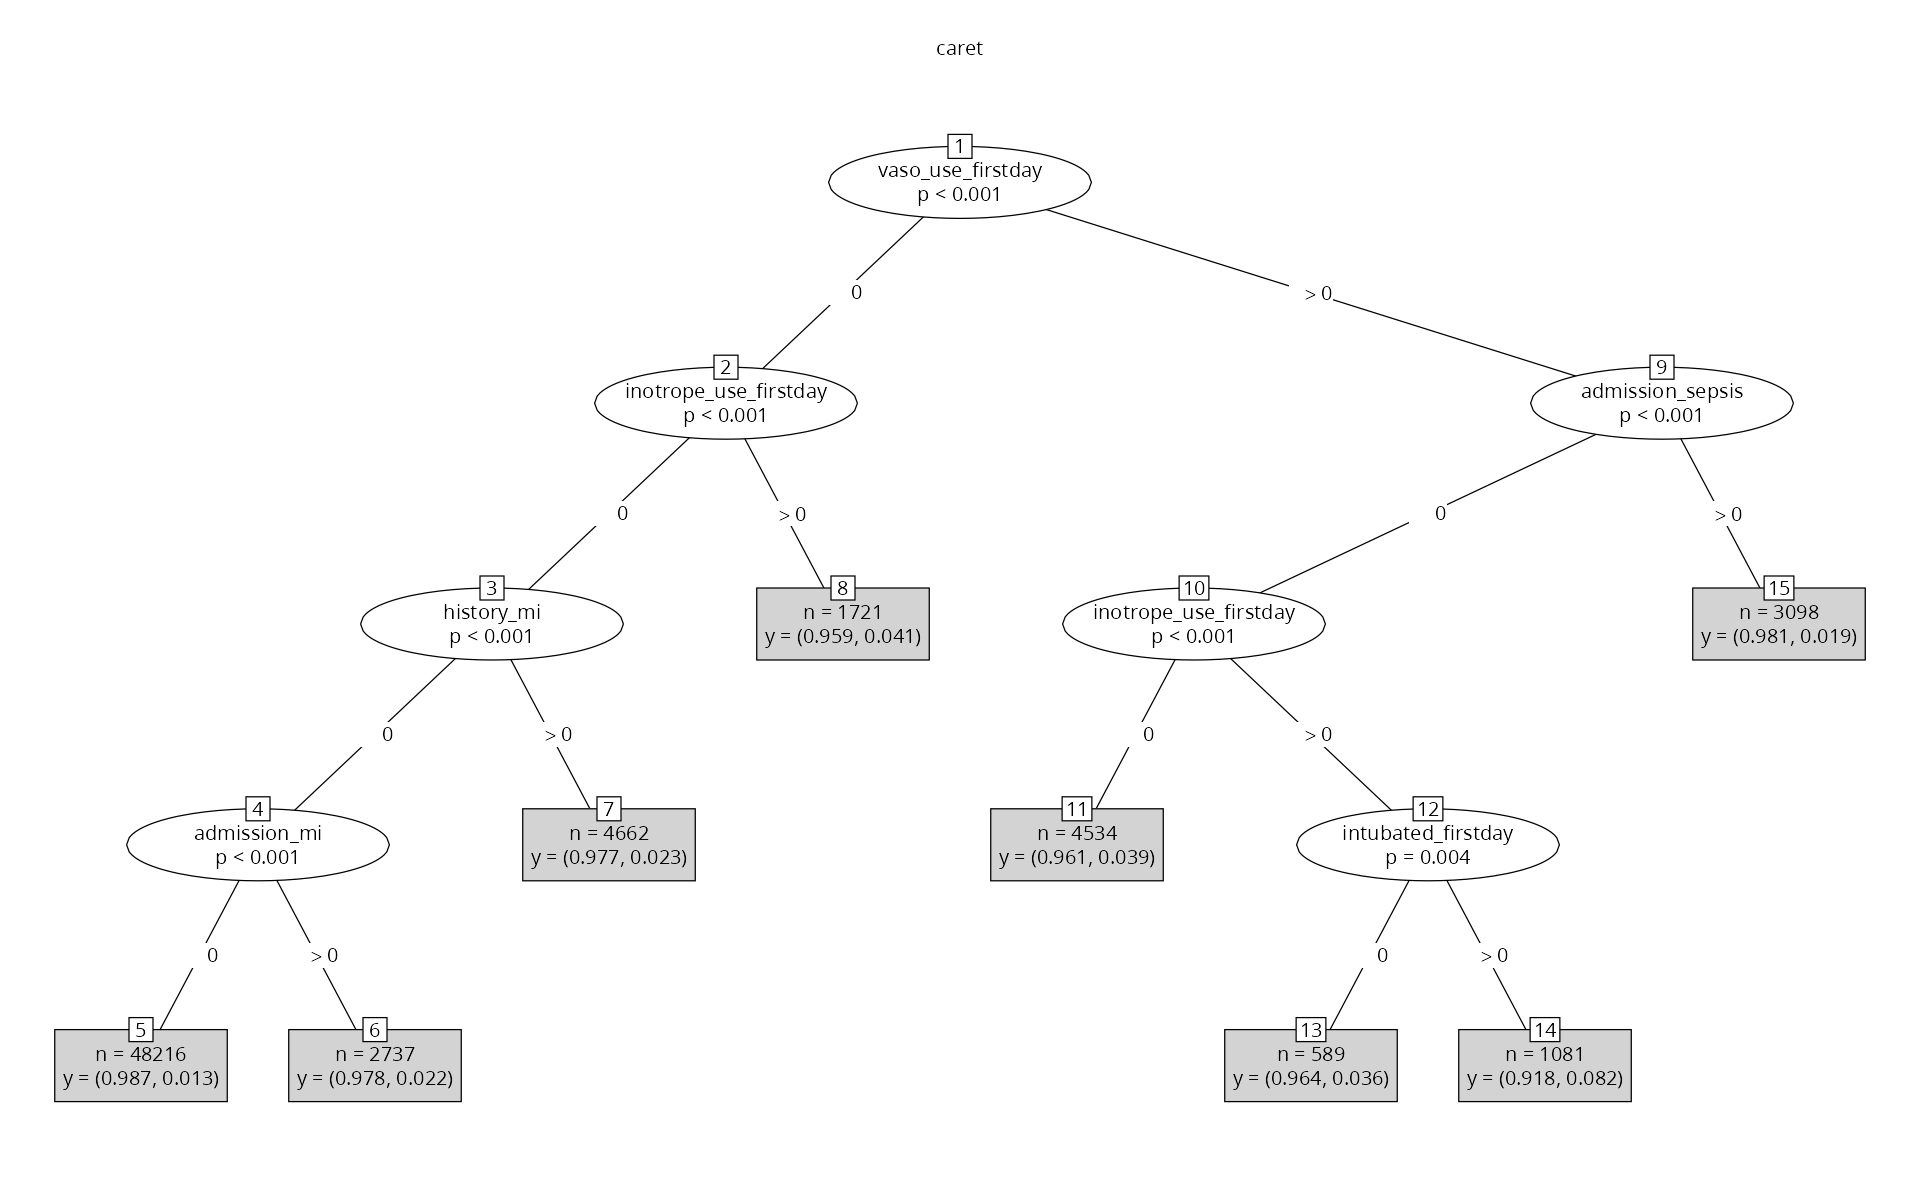

In [13]:
plot(dt_mods$caret$finalModel, type = 'simple', main = 'caret')

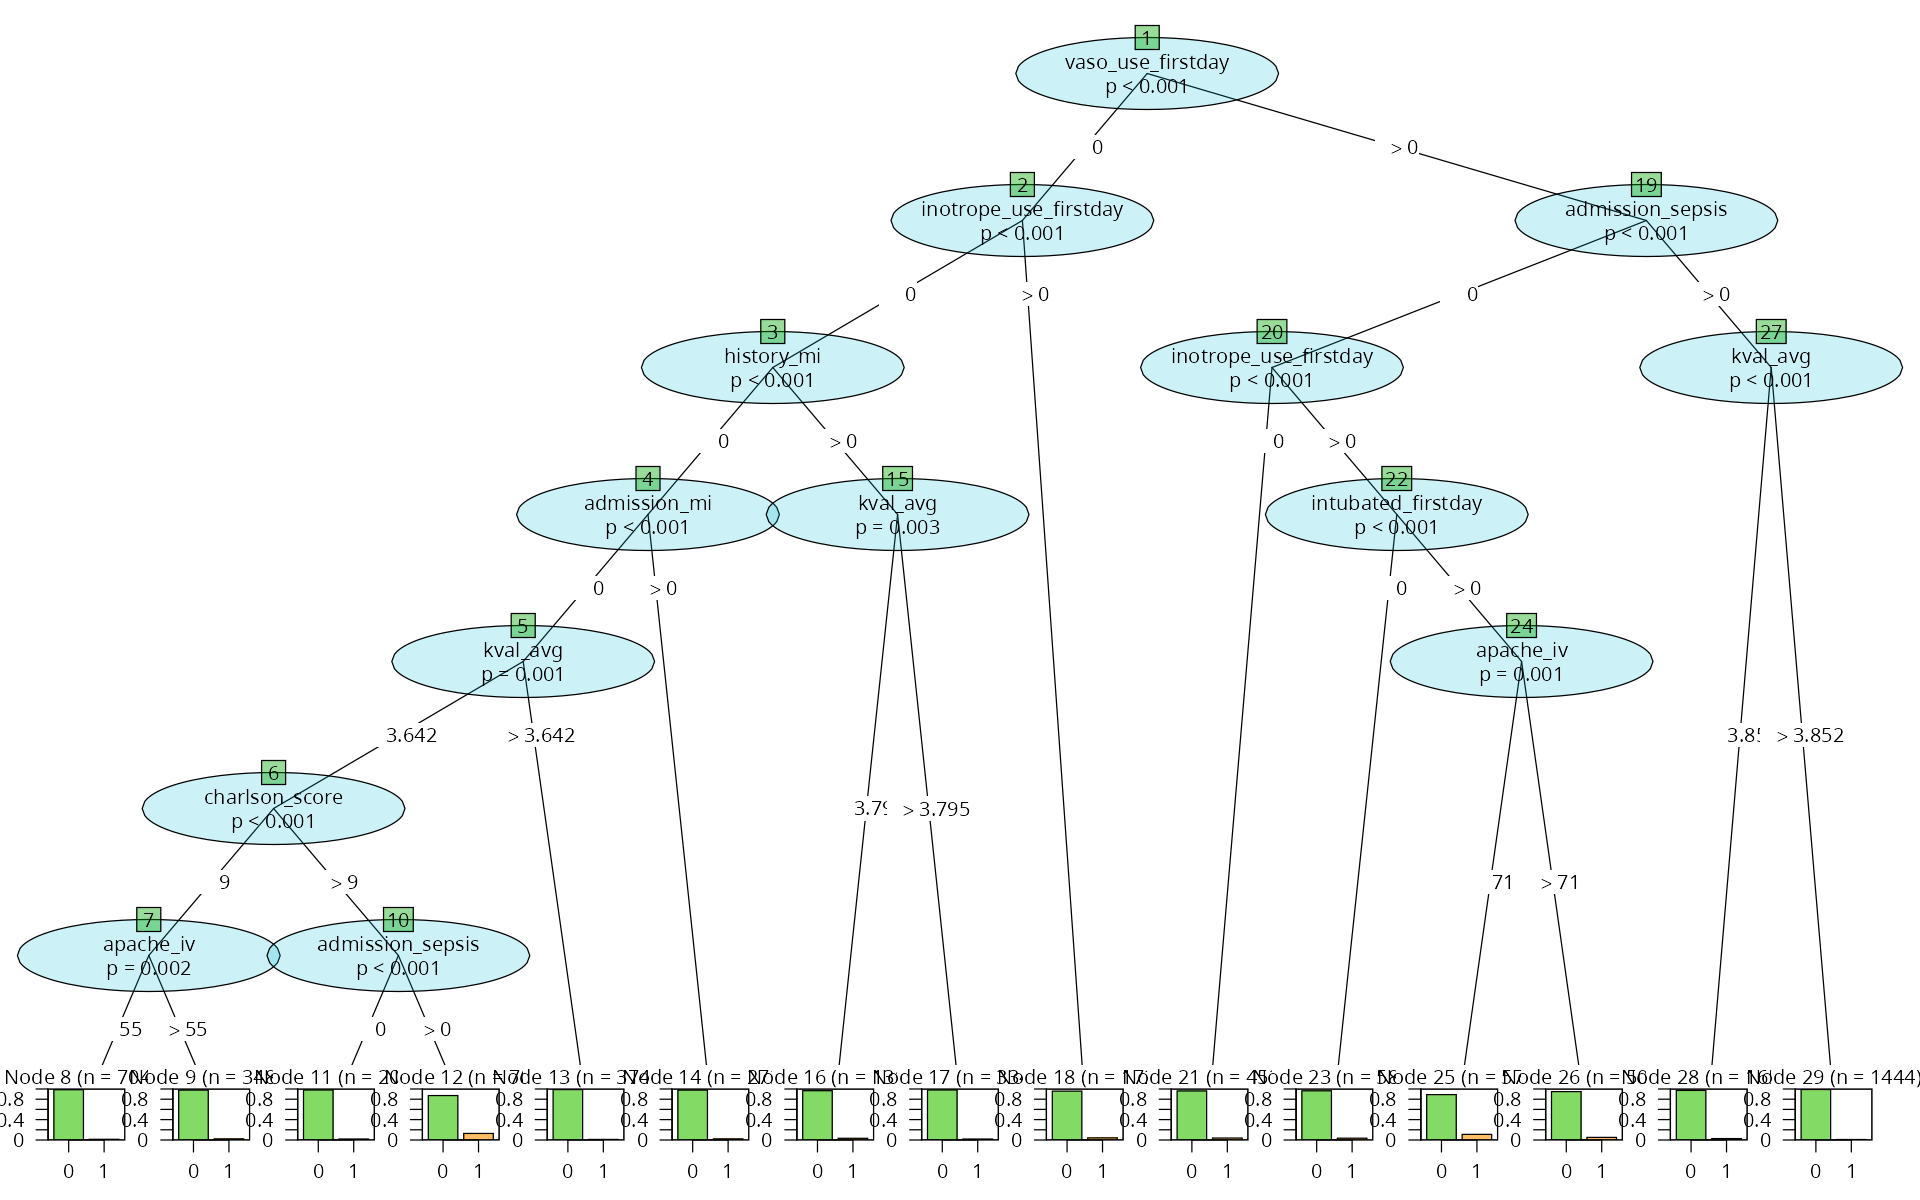

In [14]:
columncol <- hcl(c(270, 260, 250), 200, 30, 0.6)
labelcol <- hcl(200, 200, 50, 0.2)
indexcol <- hcl(150, 200, 50, 0.4)

plot(
    dt_mods$ctree, type = 'simple',
    drop_terminal = TRUE, tnex=1,
    inner_panel = partykit::node_inner(
        dt_mods$ctree, abbreviate = FALSE,
        fill = c(labelcol, indexcol), pval = TRUE, id = TRUE
    ),
    terminal_panel = partykit::node_barplot(
        dt_mods$ctree, col = 'black',
        fill = columncol[c(1,2,4)], beside = TRUE,
        ymax = 1, ylines = TRUE, widths = 1, gap = 0.1,
        reverse = FALSE, id = TRUE
    )
)

Description: 

Top - The predicted class;  
Middle - The predicted probability for Target=1;  
Bottom - Portion of observations in nodes

In [39]:
# Extract the prediction from the decision tree models
# can also use type = 'raw' → see what happens
pred_dts <- dt_mods %>% map(~ as_tibble(predict(.x, dt_test, type = 'prob')))
bind_cols(dt_res, pred_dts %>% imap(~ set_names(.x, paste0(.y, '$', names(.x)))) %>% bind_cols()) %>% head()

icustay_id,caret$0,caret$1,ctree$0,ctree$1
<int>,<dbl>,<dbl>,<dbl>,<dbl>
141244,0.9873693,0.01263066,0.9887190,0.01128101
141266,0.9768340,0.02316602,0.9808555,0.01914448
141328,0.9873693,0.01263066,0.9887190,0.01128101
141362,0.9873693,0.01263066,0.9887190,0.01128101
141373,0.9768340,0.02316602,0.9808555,0.01914448
141564,0.9587449,0.04125508,0.9587449,0.04125508


In [47]:
bind_cols(dt_res, tibble(Arythmia = pred_dts$caret$`1` > 0.5)) %>% head()

icustay_id,Arythmia
<int>,<lgl>
141244,FALSE
141266,FALSE
141328,FALSE
141362,FALSE
141373,FALSE
141564,FALSE


### Pattern quality of Decision Tree

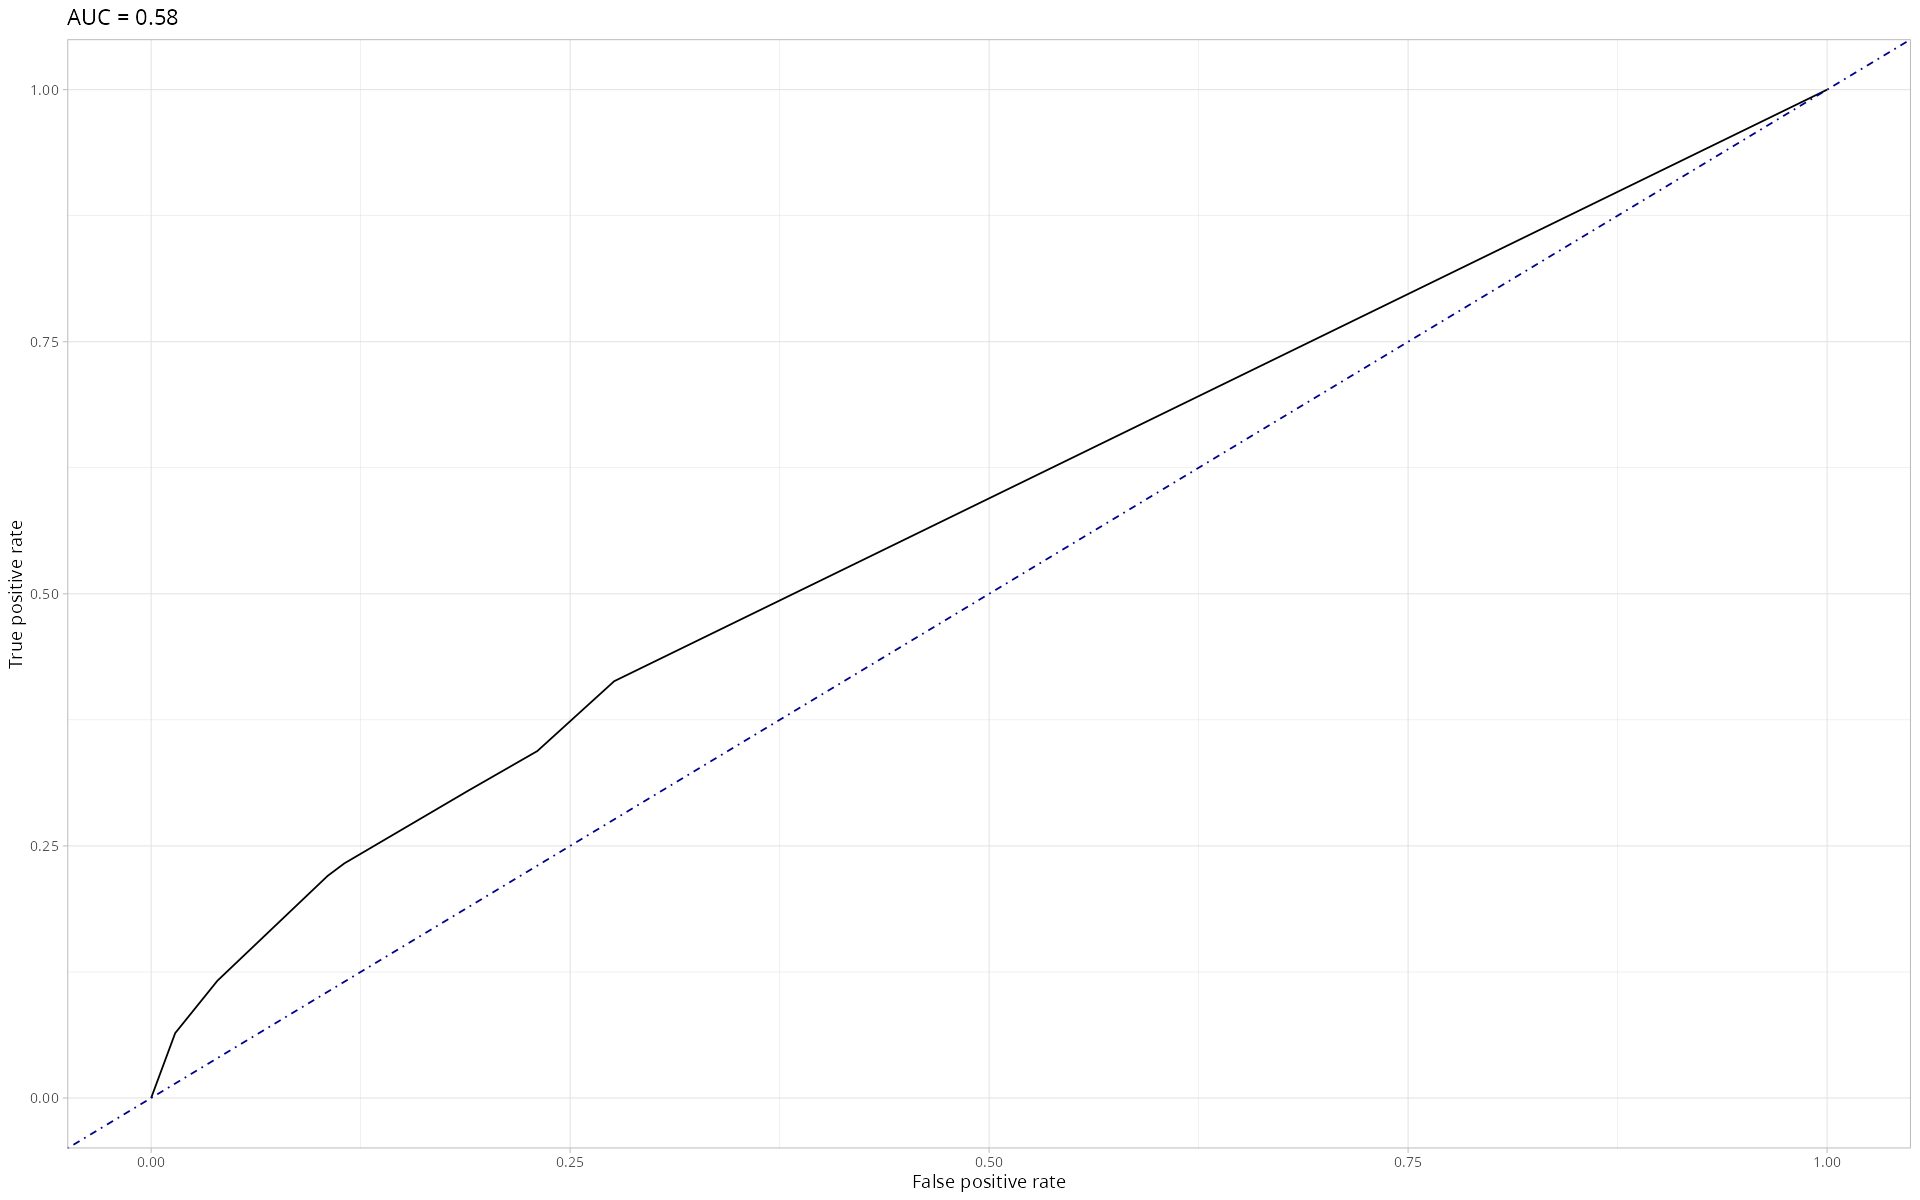

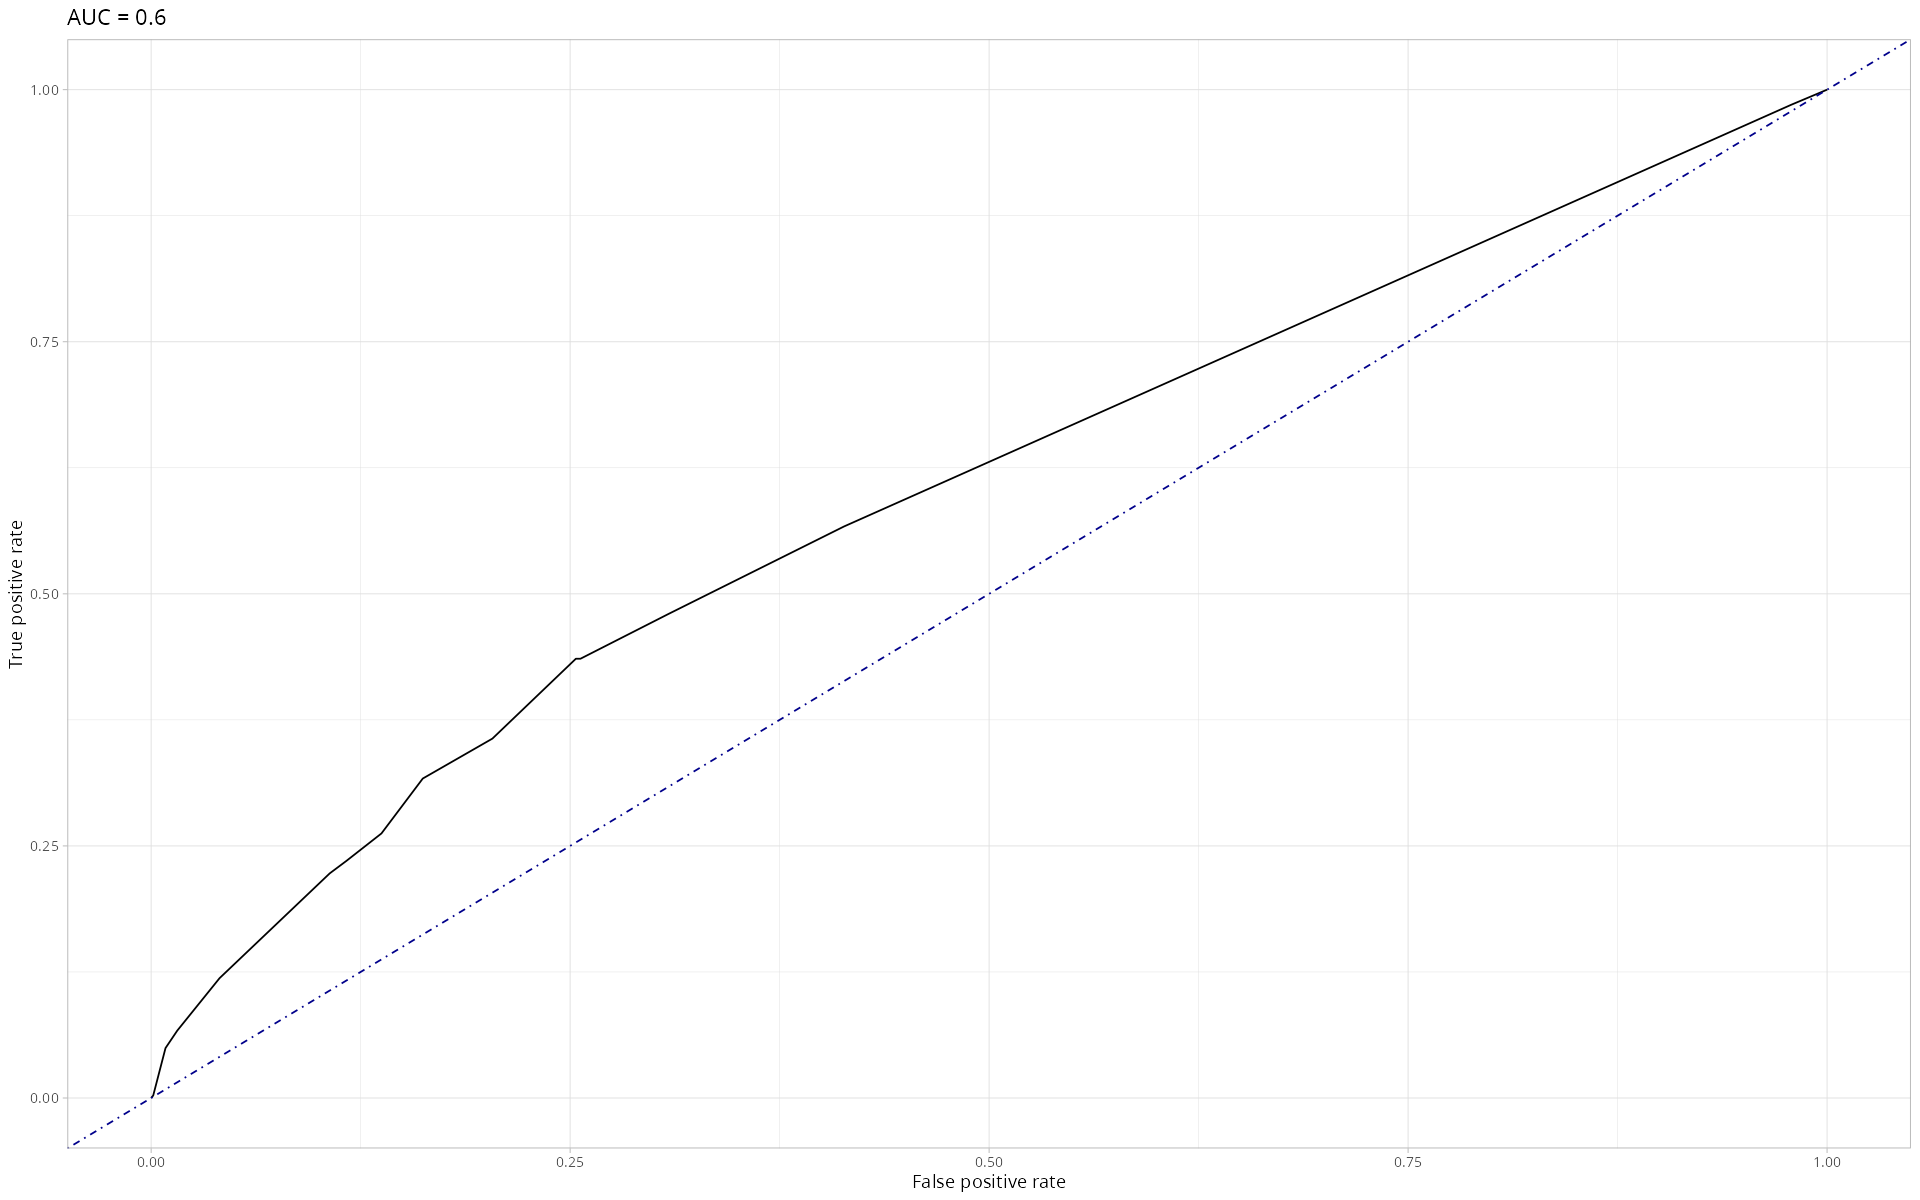

In [10]:
roc_func(pred = pred_dts$caret[, 2], dt_test)
roc_func(pred = pred_dts$ctree[, 2], dt_test)

### Variable Importance

In [11]:
var_imps <- list(
    caret = caret::varImp(dt_mods$caret),
    ctree = partykit::varimp(dt_mods$ctree) %>%
        tibble::enframe('var_name', 'var_imp')
)

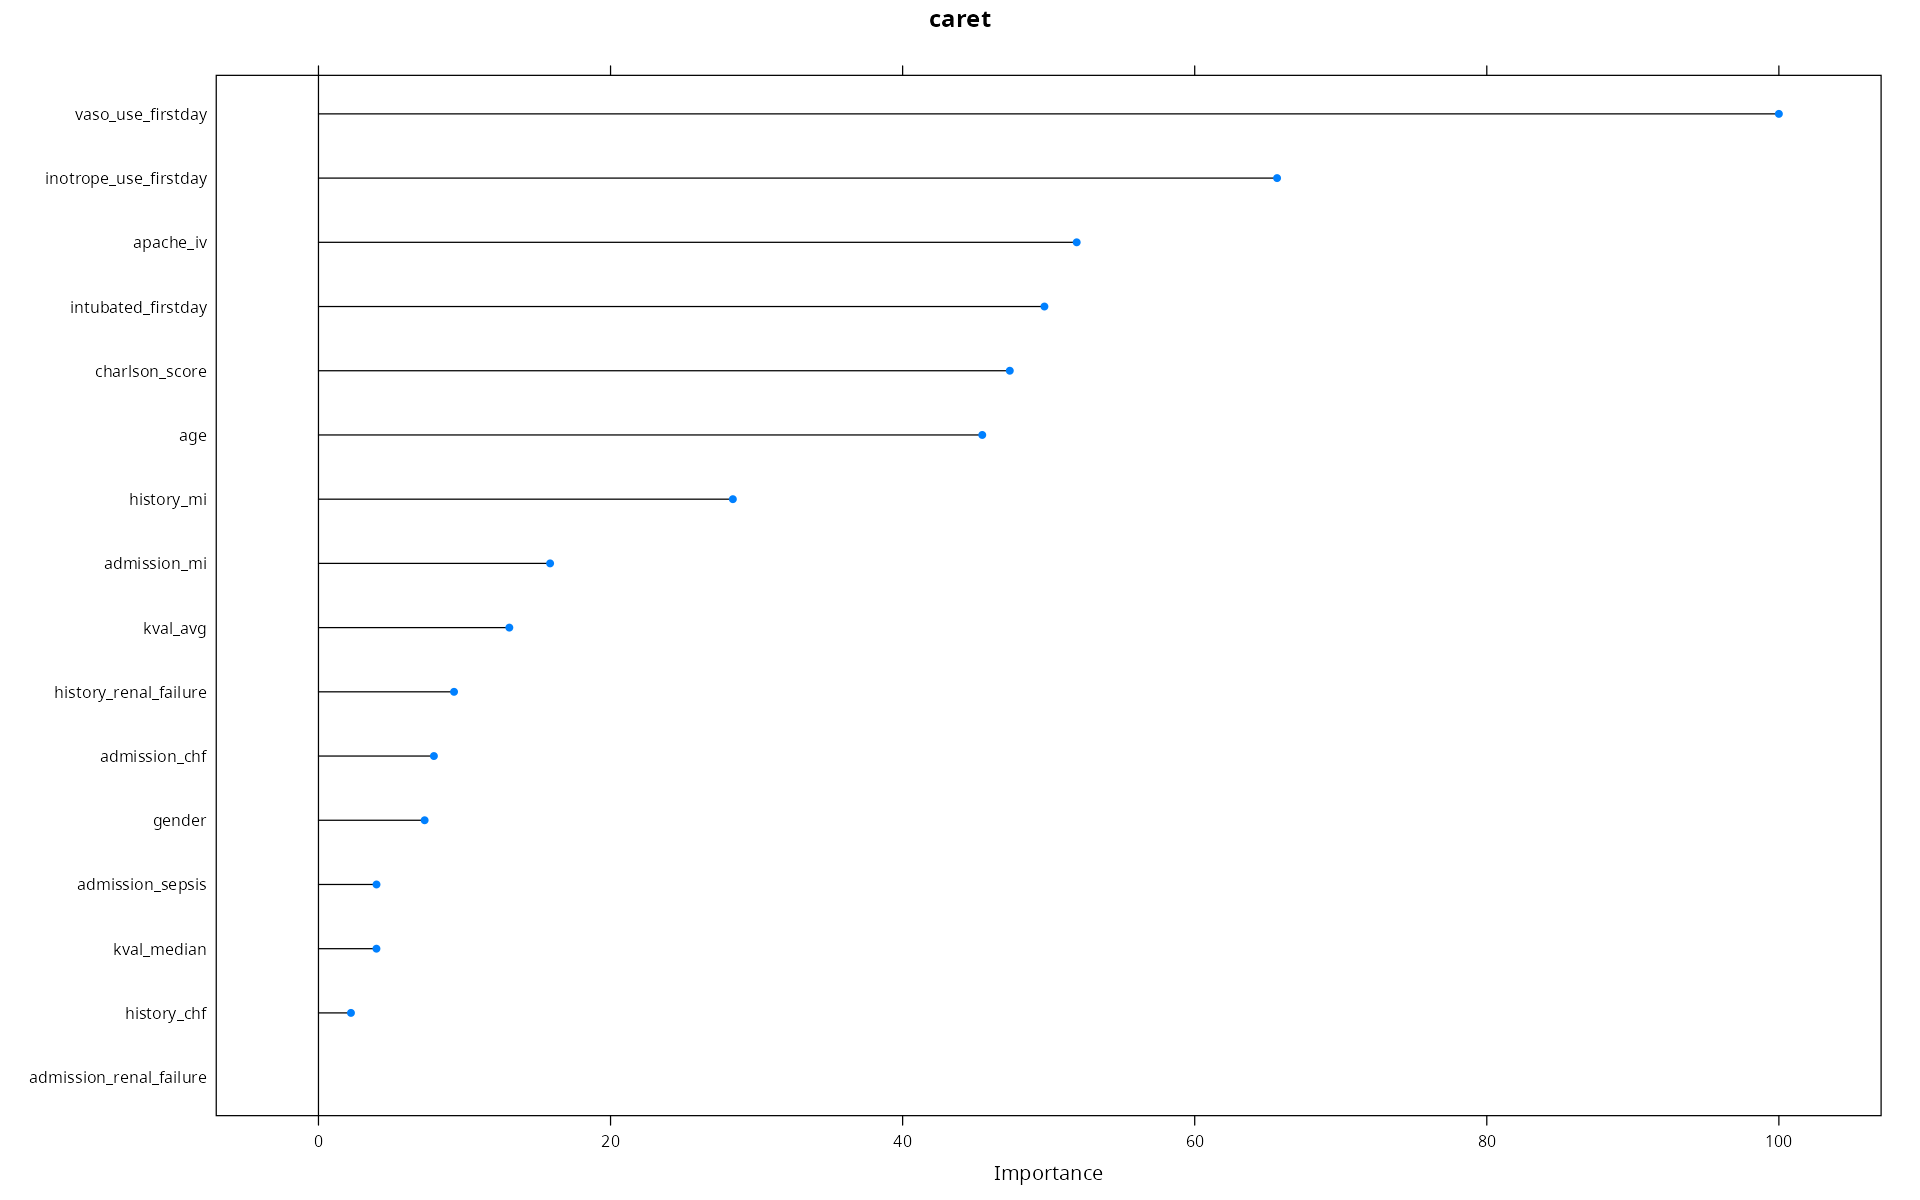

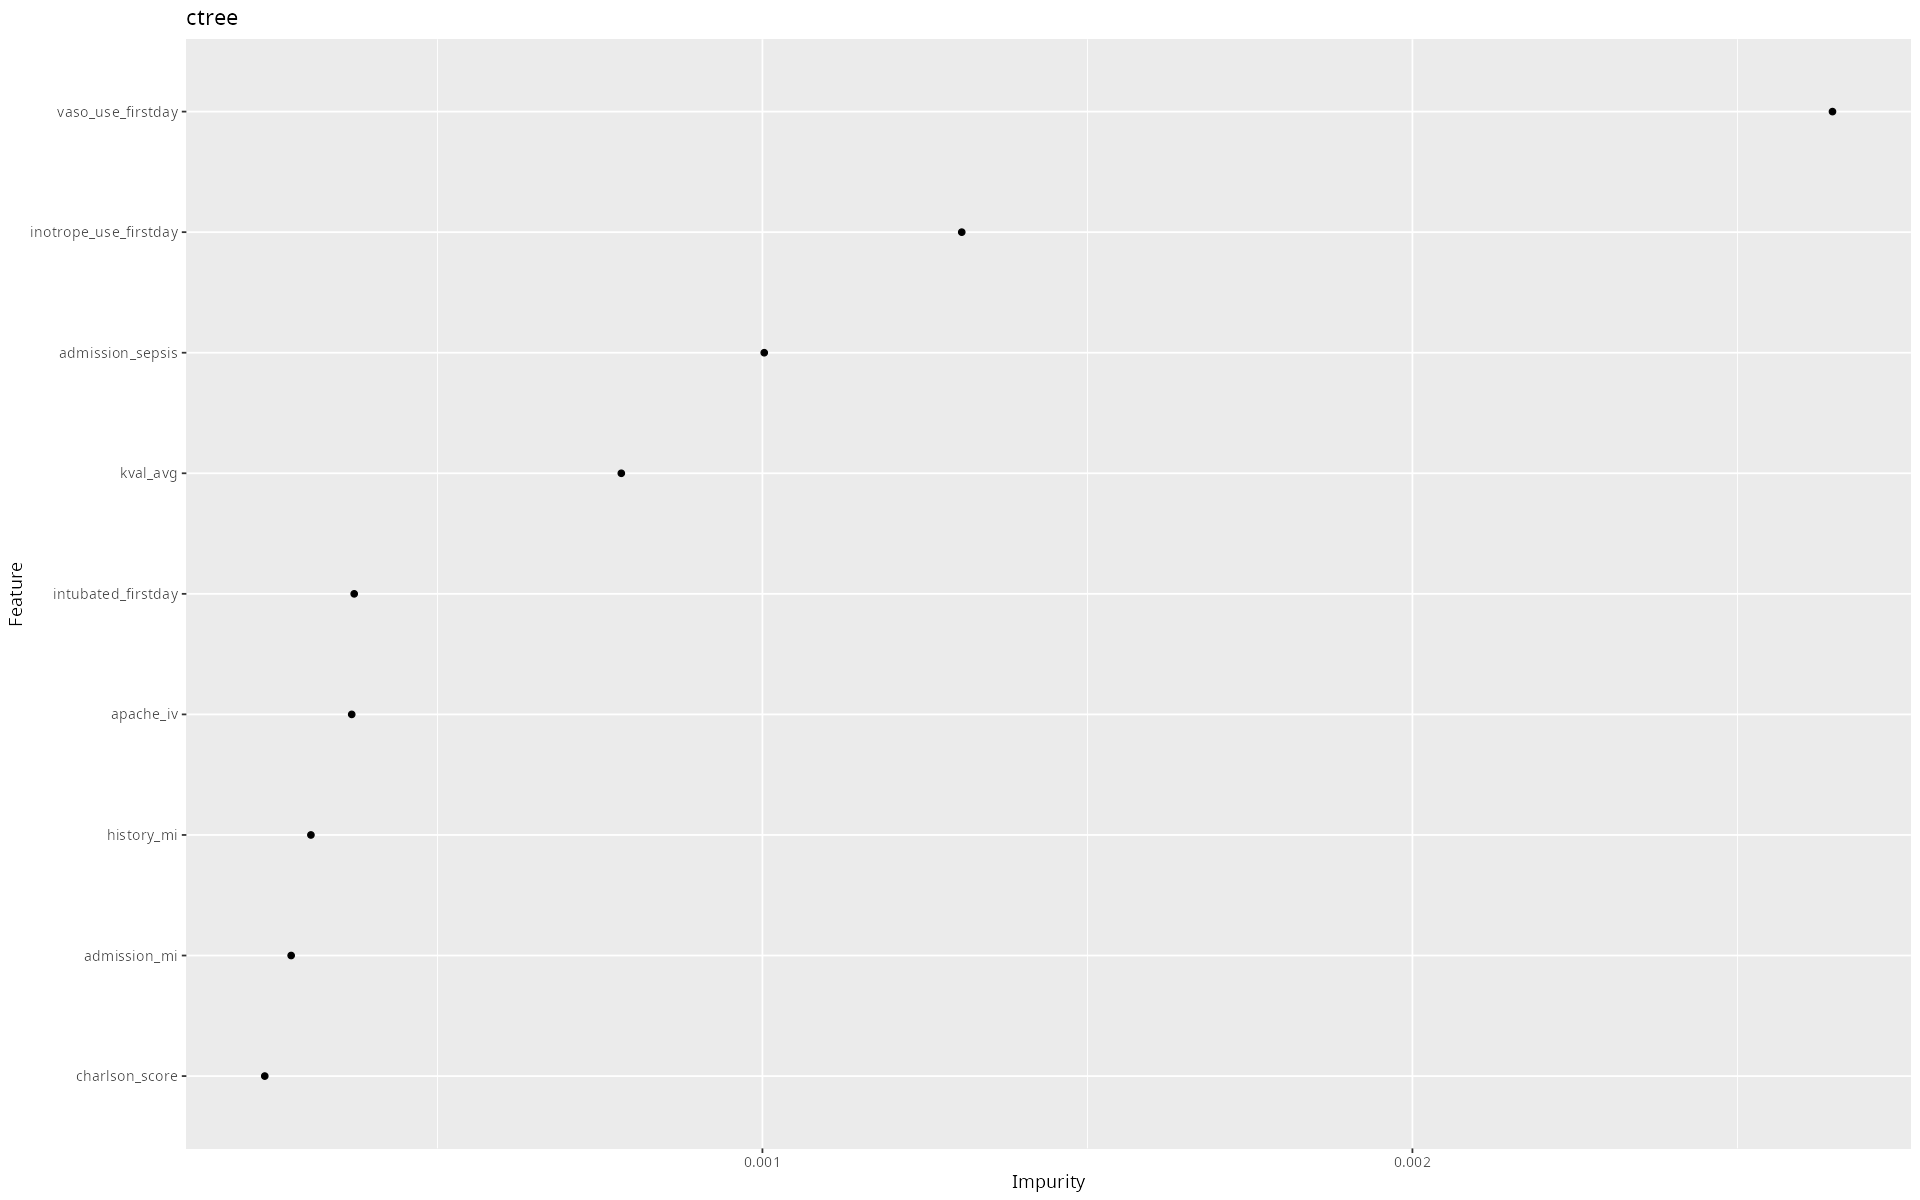

In [12]:
plot(var_imps$caret, main = 'caret')
ggplot(var_imps$ctree, aes(var_imp, reorder(var_name, var_imp))) +
    geom_point() + labs(x = 'Impurity', y = 'Feature', title = 'ctree')

## 2.3 Random Forest
### Model fit Random Forest

In [18]:
cores <- 7
doParallel::registerDoParallel(cores = cores)

#define parameters
rf_train = dt_train
rf_test = dt_test
rf_res = dt_res

# Number of variables randomly collected to be sampled at each split time.
mtry = sqrt(ncol(rf_train))
# Number of branches will grow after each time split.
ntree = 50 #100 # 2, 10, 50

#Metric compare model is Accuracy
metric <- 'Accuracy' # also other metrics possible (RMSE-> regression, Kappa->classification, etc.).. see documentation
set.seed(1)
tunegrid <- expand.grid(.mtry=mtry)
#Random generate 15 mtry values with tuneLength = 15
tunelength = 15

In [21]:
if(!('RF_models.rds') %in% list.files()) {
    start_time <- Sys.time()

    rf_mods <- list()

    ## 0. Training with ranger method
    rf_mods$ranger <- ranger::ranger(
        target ~ .,
        data = rf_train,
        num.tree = ntree,
        mtry = mtry,
        verbose = TRUE,
        #importance = 'impurity_corrected', seed = 20180713,  min.node.size = 50,
        importance = 'impurity',
        seed = 20180713,
        min.node.size = 50,
        probability = TRUE
    )

    IRdisplay::display(rf_mods$ranger)

    ## Now let's try a different one!

    ## 1. Default test
    #10 folds repeat 3 times
    rf_mods$default <- train(
        target ~ .,
        data       = rf_train,
        method     = 'rf', # can also try cforest!
        metric     = metric,
        tuneGrid   = tunegrid,
        ntree      = ntree,
        trControl  = trainControl(
            method = 'cv', # method = 'repeatedcv', method = 'boot', method = 'oob'
            number = 5 #, repeats = 5
            ## what's wrong here?? 5-fold cross validation? 
            ## What's the standard? 10 or 25!
        )
    )
    IRdisplay::display(rf_mods$default)

    ## 2. Random search
    rf_mods$random <- train(
        target ~ .,
        data       = rf_train,
        method     = 'rf', # can also try cforest!
        metric     = metric, 
        tuneGrid   = tunegrid, 
        ntree      = ntree,
        tuneLength = tunelength, 
        trControl  = trainControl(
            method  = 'cv',  #"repeatedcv",
            #repeats  = 5, 
            number   = 5, ## 10 fold repeat 3x
            search   = 'random'
        )
    )
    IRdisplay::display(rf_mods$random)

    rf_mods$time <- Sys.time() - start_time
    saveRDS(rf_mods, 'RF_models.rds')
} else {
    rf_mods <- readRDS('RF_models.rds')
}
cat('Execution time:\n')
rf_mods$time
rf_mods$time <- NULL

Ranger result

Call:
 ranger::ranger(target ~ ., data = rf_train, num.tree = ntree,      mtry = mtry, verbose = TRUE, importance = "impurity", seed = 20180713,      min.node.size = 50, probability = TRUE) 

Type:                             Probability estimation 
Number of trees:                  50 
Sample size:                      66638 
Number of independent variables:  16 
Mtry:                             4 
Target node size:                 50 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.01779115 

Random Forest 

66638 samples
   16 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 53310, 53311, 53310, 53311, 53310 
Resampling results:

  Accuracy   Kappa
  0.9820973  0    

Tuning parameter 'mtry' was held constant at a value of 4.123106

Random Forest 

66638 samples
   16 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 53310, 53311, 53310, 53310, 53311 
Resampling results:

  Accuracy   Kappa
  0.9820973  0    

Tuning parameter 'mtry' was held constant at a value of 4.123106

Execution time:


Time difference of 21.88685 secs

In [36]:
## get prediction
preds_rf <- map(rf_mods, ~ {
    if ('ranger' %in% class(.x)) predict(.x, rf_test)$predictions %>% as.data.frame()
    else predict(.x, rf_test, type = 'prob')
})
preds_rf %>% imap(~ set_names(.x, paste0(.y, '$', names(.x)))) %>% bind_cols() %>% head()

,ranger$0,ranger$1,default$0,default$1,random$0,random$1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9812370,0.01876297,1.00,0.00,1.00,0.00
2,0.9796018,0.02039820,1.00,0.00,0.98,0.02
3,0.9681184,0.03188162,0.92,0.08,0.92,0.08
4,0.9893834,0.01061661,0.96,0.04,1.00,0.00
5,0.9818292,0.01817076,0.98,0.02,0.98,0.02
6,0.9782857,0.02171428,0.96,0.04,0.96,0.04


### Pattern quality Random Forest

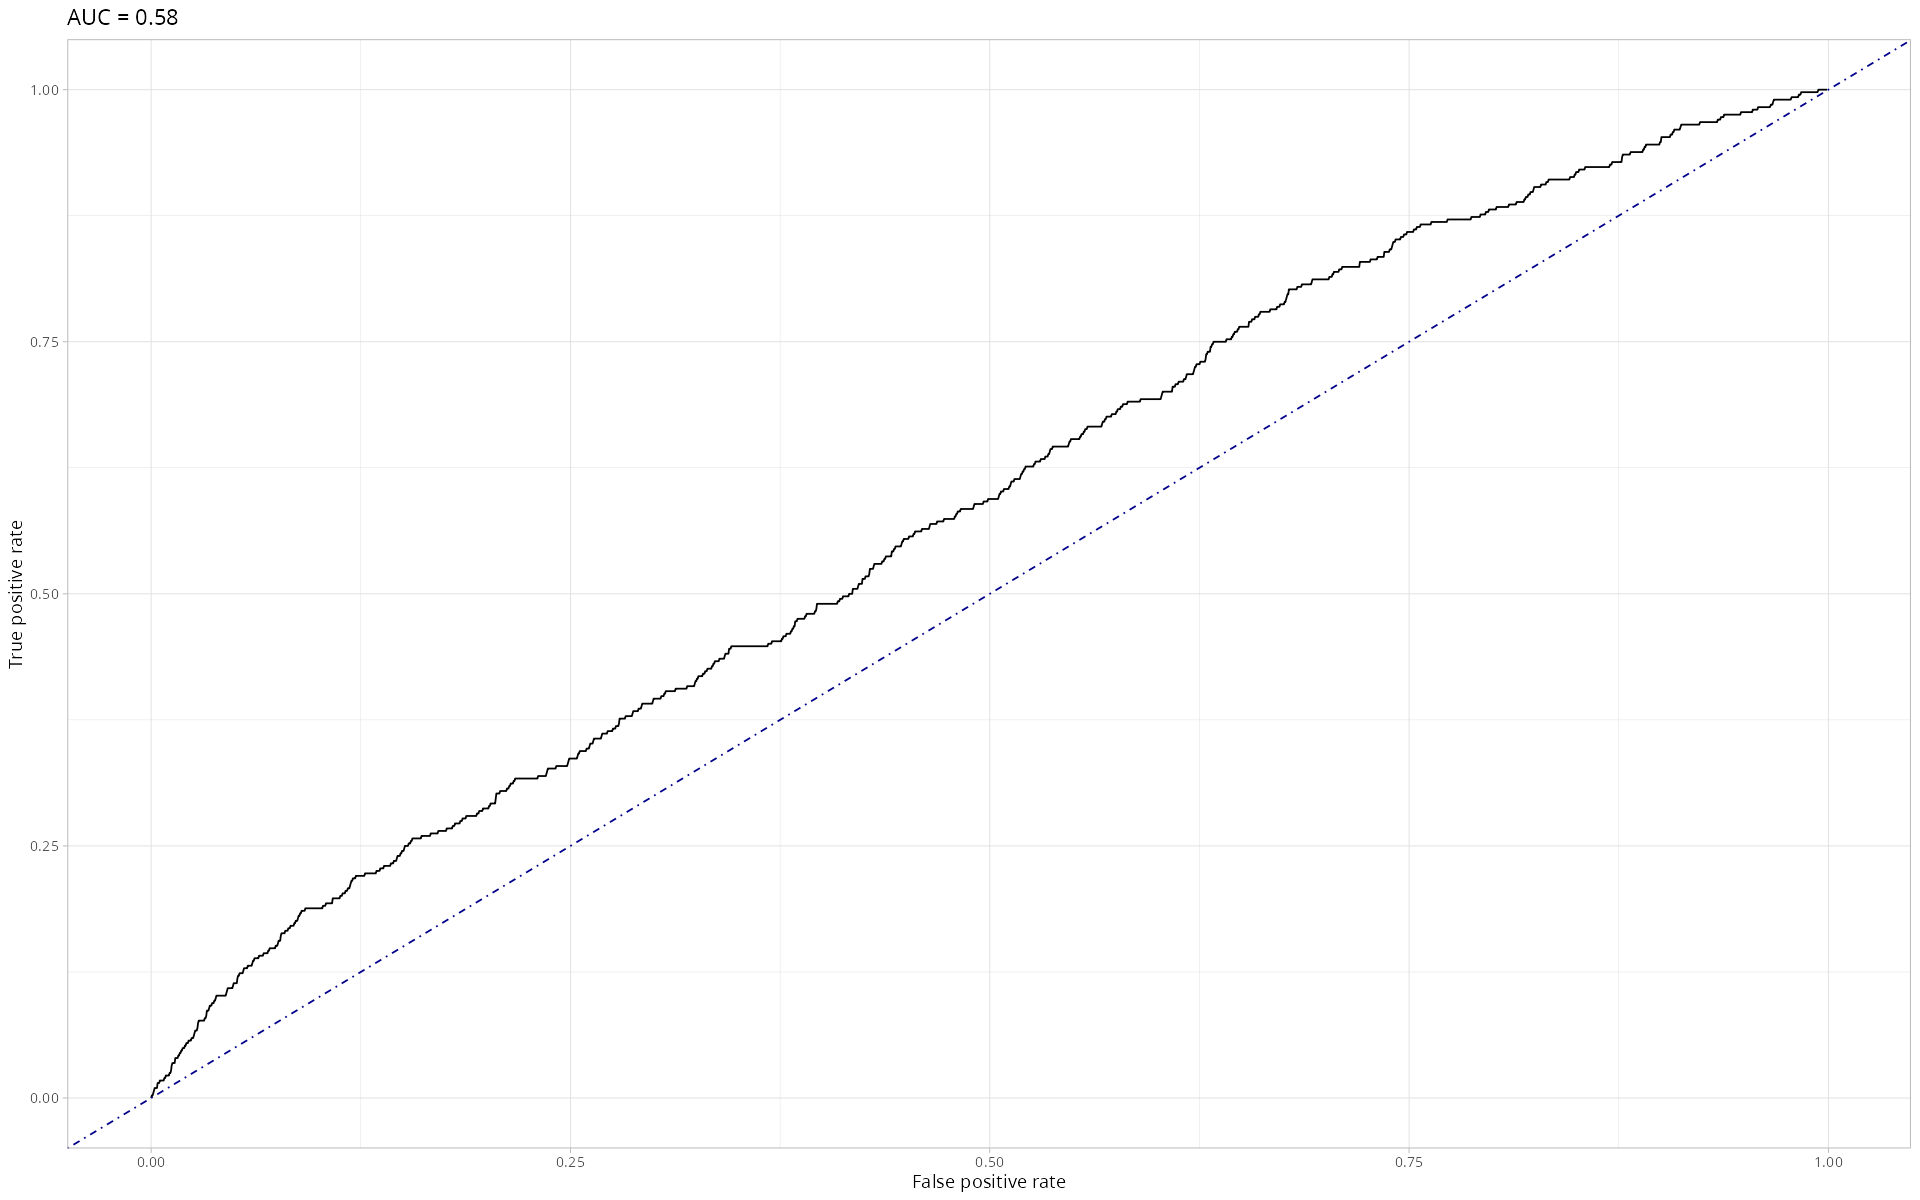

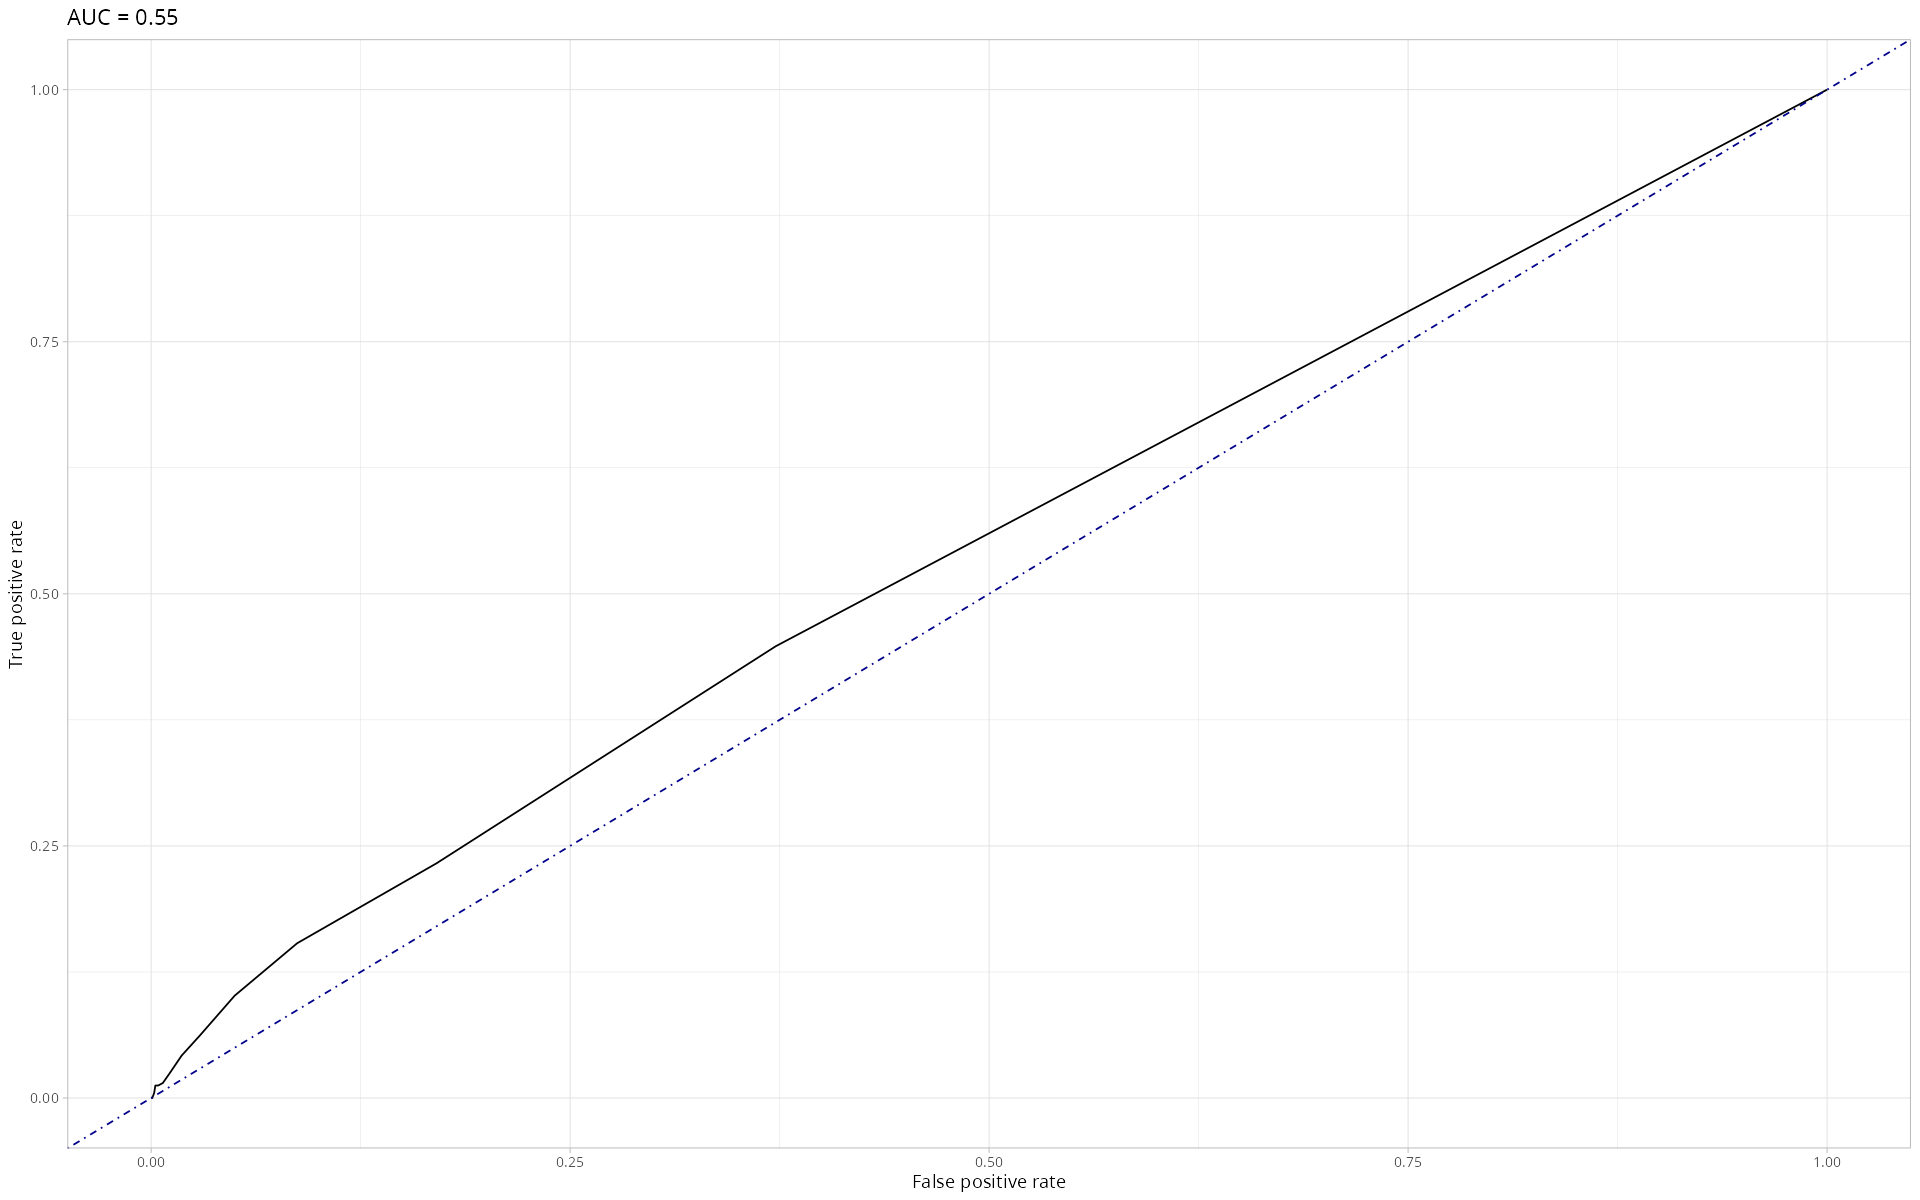

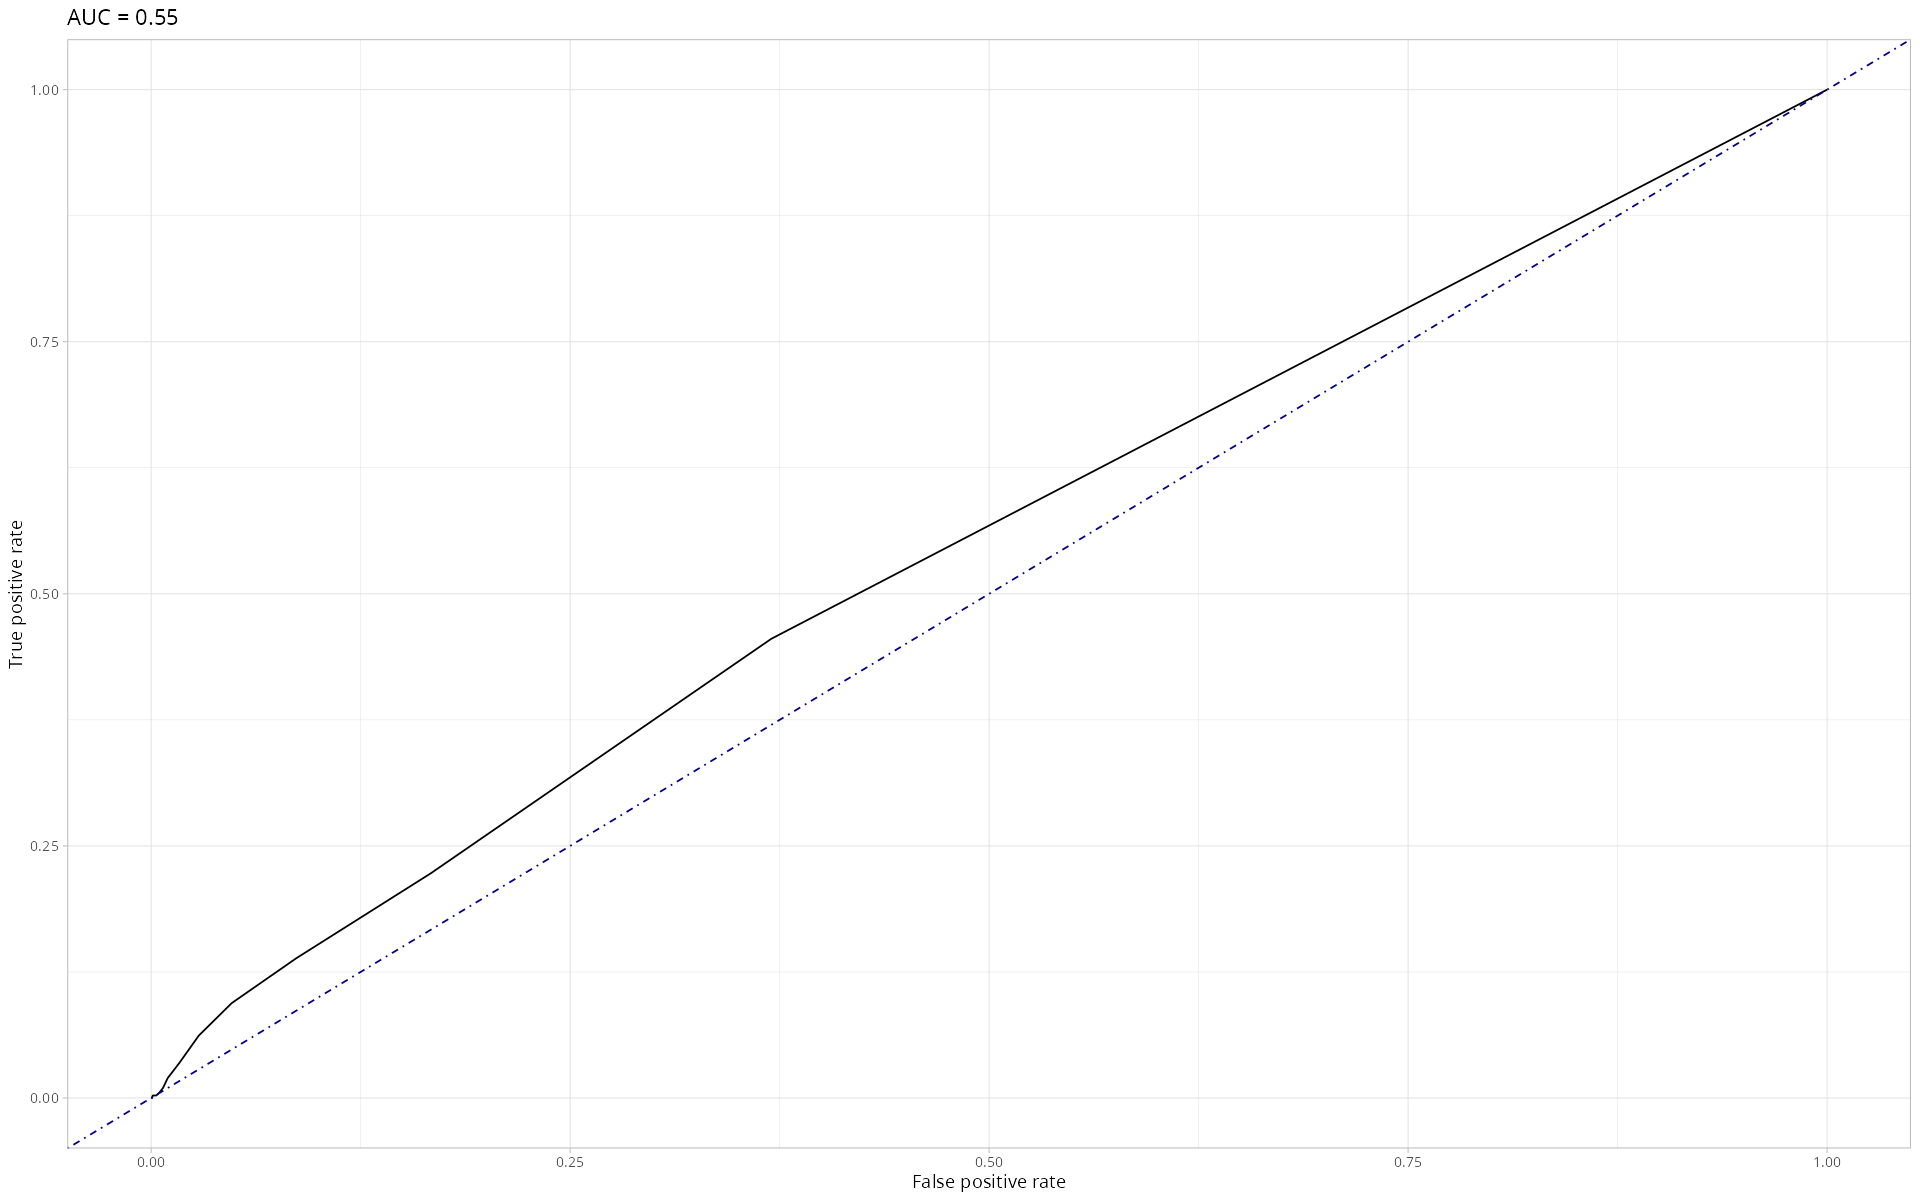

In [27]:
# ROC curve
roc_func(preds_rf$ranger[, 2], rf_test)
roc_func(preds_rf$default[, 2], rf_test)
roc_func(preds_rf$random[ ,2], rf_test)

### Variable Importance

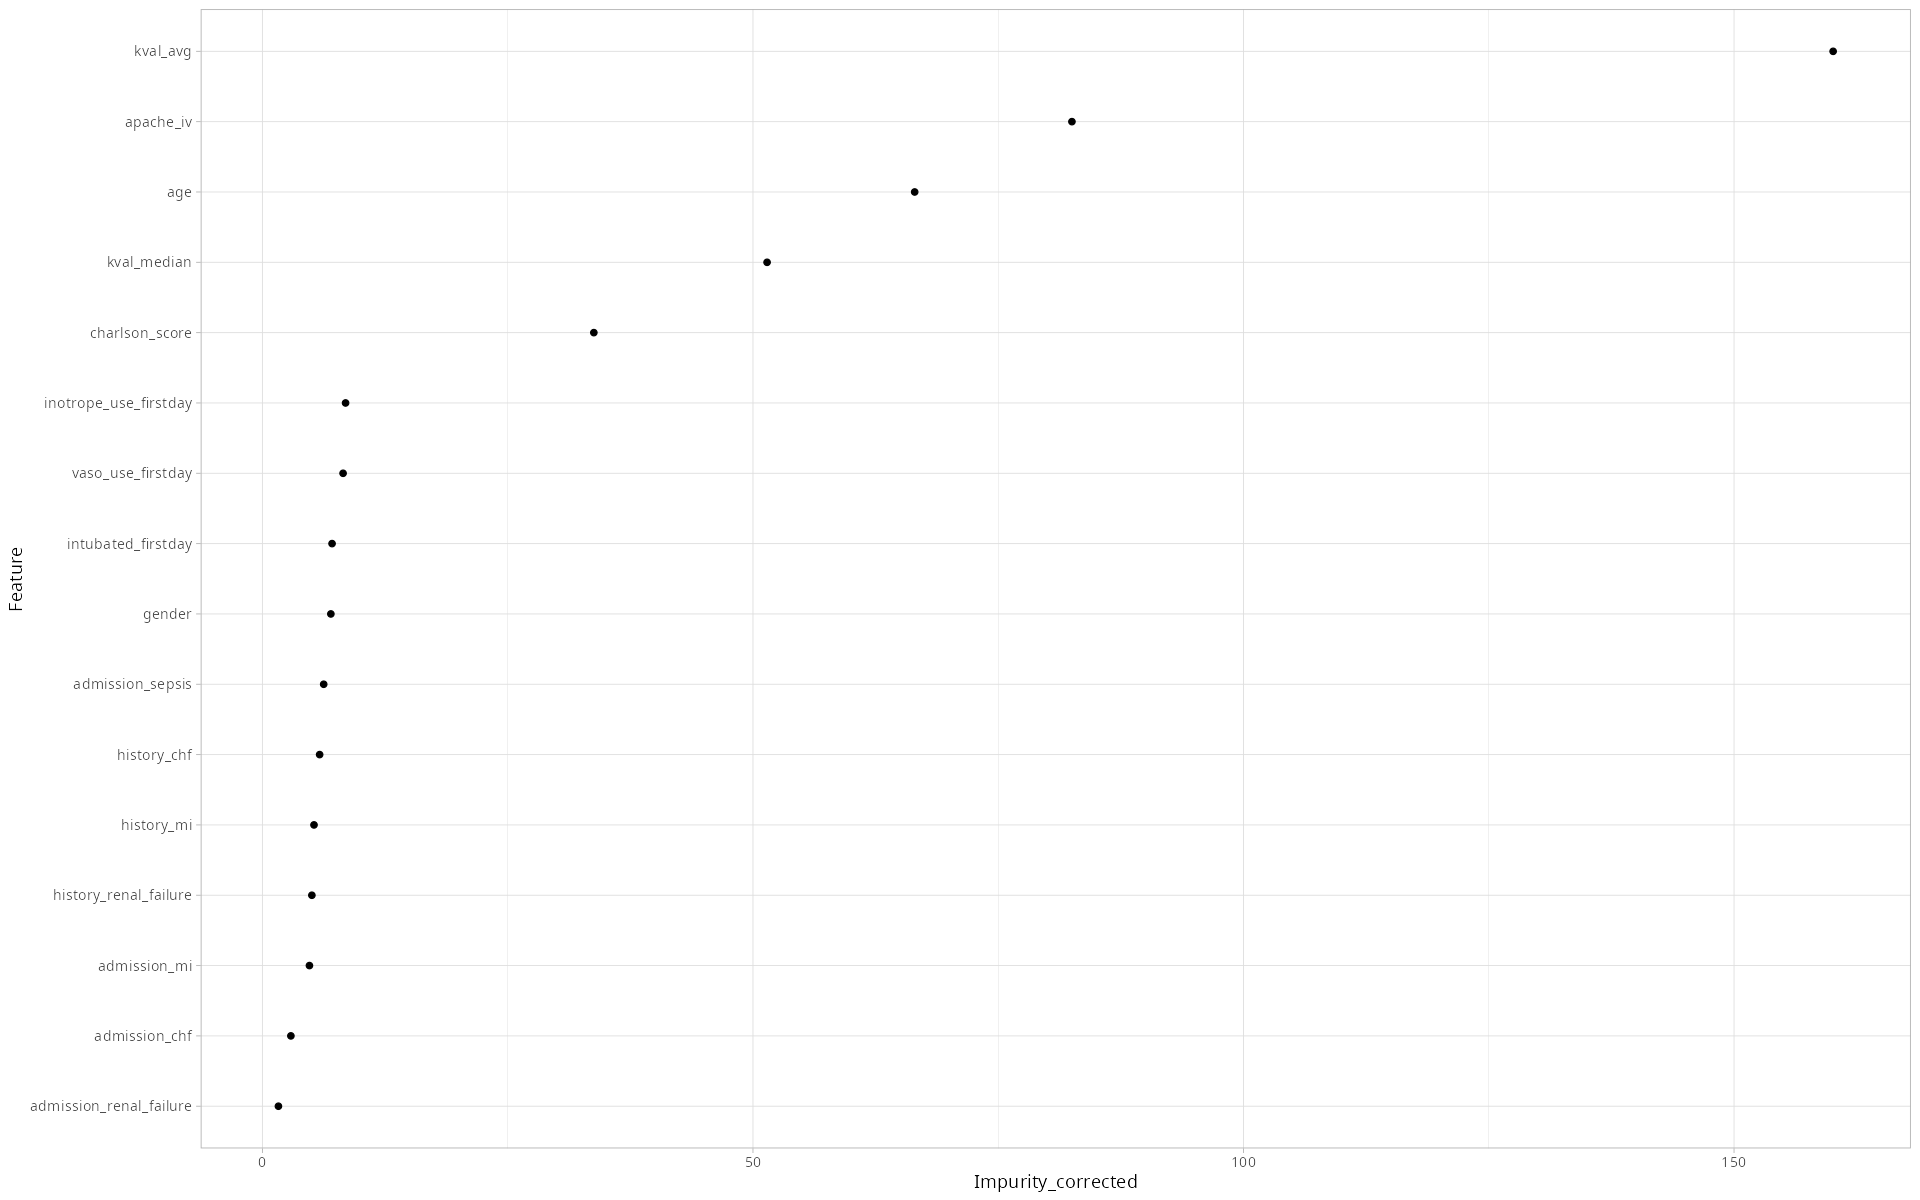

In [28]:
var_imps <- list(
    ranger = ranger::importance(rf_mods$ranger) %>% tibble::enframe('var_name', 'var_imp')#,
    # default = randomForest::importance(rf_mods$default) %>% as_tibble(),
    # random = randomForest::importance(rf_mods$random) %>% as_tibble(),
)

ggplot(var_imps$ranger, aes(x = var_imp, y = reorder(var_name, var_imp))) + geom_point() + theme_light() +
    labs(x = 'Impurity_corrected', y = 'Feature')

# Homework

- Why use a training and a test set?  
  What happens when you uncomment and use ctree_no_split?
- Why is cross validation technically unnecessary for random forests?
- Why do our decision trees perform better than our random forests?

### 3. Grid Search

In [23]:
control <- trainControl(
    method = 'cv',
    number = 5,
    search = 'grid'
)
# create tunegrid with 4 values from 1:4 for mtry to tune the model.
# Our train function will change number of entry variable at each split according to tunegrid. 
tunegrid <- expand.grid(.mtry = 1:4)

rf_gridsearch <- train(
    target ~ .,
    data     = rf_train,
    method   = 'rf',
    metric   = metric,
    tuneGrid = tunegrid
)
rf_gridsearch
plot(rf_gridsearch)

### 4. Tune manually

In [31]:
cores <- parallel::makeCluster(4)
doParallel::registerDoParallel(cores = cores)
control <- trainControl(
    method = 'cv',
    number = 10,
    search = 'grid'
)
#create tunegrid
tunegrid <- expand.grid(.mtry = c(sqrt(ncol(rf_train))))
modellist <- list()
# train with different ntree parameters
for (ntree in c(1000, 1500, 2000, 2500)) {
    set.seed(123)
    fit <- train(
        target ~ .,
        data      = rf_train,
        method    = 'rf',
        metric    = 'Accuracy',
        tuneGrid  = tunegrid,
        trControl = control,
        ntree     = ntree
    )
    key <- toString(ntree)
    modellist[[key]] <- fit
}

#Compare results
results <- resamples(modellist)
summary(results)
dotplot(results)